<a href="https://colab.research.google.com/github/yeetmao/Eclipsing-Binaries-Light-Curves/blob/main/TESS_Light_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroquery astropy matplotlib scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.6/997.6 kB 30.9 MB/s eta 0:00:00


Adjusted from code provided

Fits list:  ['mastDownload/TESS/tess2018349182500-s0006-0000000033419790-0126-s/tess2018349182500-s0006-0000000033419790-0126-s_lc.fits']
Opening file: mastDownload/TESS/tess2018349182500-s0006-0000000033419790-0126-s/tess2018349182500-s0006-0000000033419790-0126-s_lc.fits


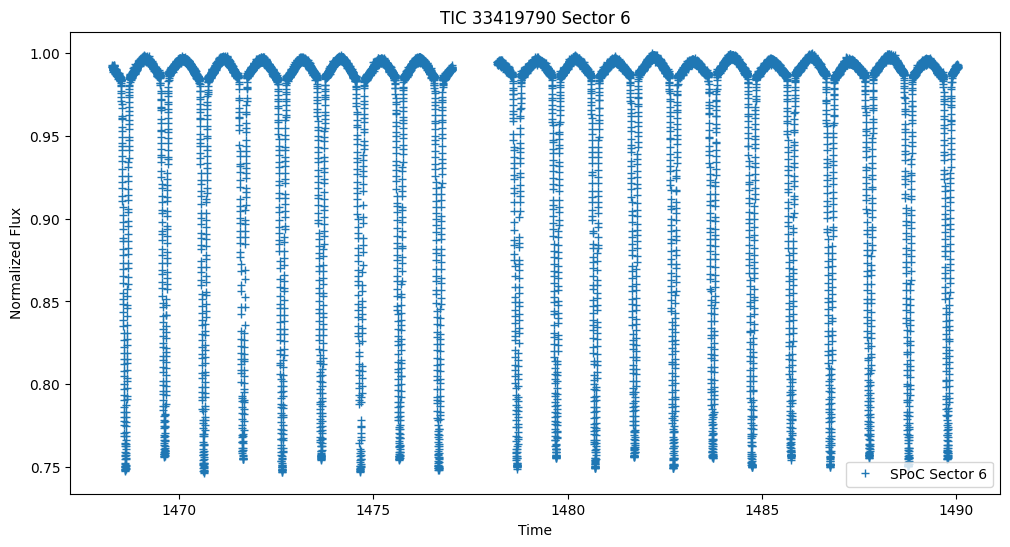

Fits list:  []
	Found 17 objects:
 intentType obs_collection provenance_name instrument_name ... mtFlag srcDen   obsid     objID  
---------- -------------- --------------- --------------- ... ------ ------ --------- ---------
   science           TESS            SPOC      Photometer ...  False    nan  27475541  70535316
   science           TESS            SPOC      Photometer ...  False    nan  62289778 116683513
   science           TESS            SPOC      Photometer ...  False    nan  27738195 116683685
   science           TESS            SPOC      Photometer ...  False    nan  62347268 117017422
   science           TESS            SPOC      Photometer ...  False    nan  62790230 120240950
   science           TESS            SPOC      Photometer ...  False    nan  64265131 120240976
   science           TESS            SPOC      Photometer ...  False    nan  91542435 175262406
   science           TESS            SPOC      Photometer ...  False    nan  93768371 182241040
   sc

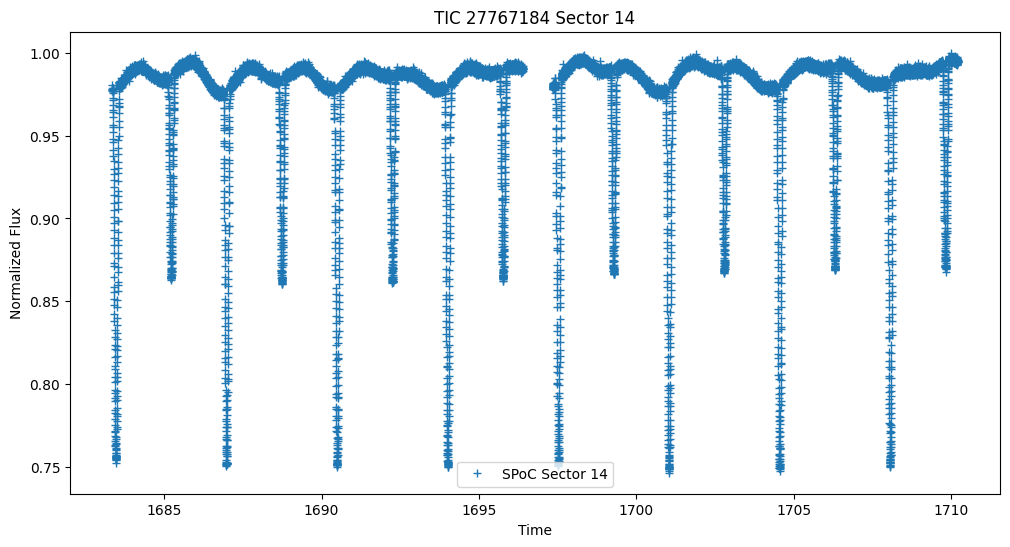

In [6]:
"""Interface for downloading LCs by TIC in Google Colab."""

import os
from glob import glob
import re

from matplotlib import pyplot as plt
from astroquery.mast import Observations
from astropy.io import fits
import numpy as np
from scipy.linalg import lstsq

# Placeholder for data_fnames: update the path to your catalog FITS file as needed.
# You can also create a separate module/file if you prefer.
data_fnames = {
    "ja21": "path_to_your_catalog.fits"  # <-- Update with your actual FITS file path.
}

# Uncomment and use if you want to use lightkurve (and install it)
# !pip install lightkurve
# import lightkurve

def get_astroquery(tic, sector, provenance="SPOC", plot=False):
    """Return the lightcurve using astroquery interface."""

    sector_str = "*" if sector == "all" else f"{sector:04d}"
    sector_tic_fname_part = f"s{sector_str}-{tic:016d}"

    if provenance == "QLP":
        fits_list = glob(
            os.path.join(
                "mastDownload",
                "HLSP",
                f"hlsp_qlp_tess_ffi_{sector_tic_fname_part}_tess_v01_llc",
                f"hlsp_qlp_tess_ffi_{sector_tic_fname_part}_tess_v01_llc.fits"
            )
        )
        parse_sector_rex = re.compile(
            r".*hlsp_qlp_tess_ffi_s(?P<sector>[0-9]*)-[0-9]*_tess_v01_llc"
        )
    else:
        fits_list = glob(
            os.path.join(
                "mastDownload",
                "TESS",
                f"tess*-{sector_tic_fname_part}-*-s",
                f"tess*-{sector_tic_fname_part}-*-s_lc.fits"
            )
        )
        parse_sector_rex = re.compile(
            r".*tess.*-s(?P<sector>[0-9]*)-[0-9]*-.*-s"
        )

    print("Fits list: ", fits_list)
    # If sector is not "all", expect only one file
    if fits_list and sector != "all":
        assert len(fits_list) == 1, "Expected one lightcurve file per sector"

    if fits_list:
        fits_list = [
            (fits_fname, int(parse_sector_rex.match(fits_fname)["sector"]))
            for fits_fname in fits_list if parse_sector_rex.match(fits_fname)
        ]
    else:
        # No local file found, query MAST:
        objects = Observations.query_criteria(
            target_name=str(tic), project="TESS", provenance_name=provenance
        )
        print(f"\tFound {len(objects)} objects:\n", objects)

        selection = np.logical_and(
            objects["obs_collection"] == ("TESS" if provenance == "SPOC" else "HLSP"),
            objects["dataproduct_type"] == "timeseries",
        )
        selection = np.logical_and(selection, objects["project"] == "TESS")

        print("\tAvailable sectors: ", objects["sequence_number"][selection])
        if sector != "all":
            selection = np.logical_and(
                selection, objects["sequence_number"] == sector
            )
            print("\tSelected objects from sectors: ", objects[selection]["sequence_number"])
        print(f"\tSelected {selection.sum()}/{len(objects)} objects")
        fits_list = []
        for get_object in objects[selection]:
            products = Observations.get_product_list(get_object)
            print("\tFound products:", products)
            product_selection = (products["productType"] == "SCIENCE") & (
                products["description"] == ("Light curves" if provenance == "SPOC" else "FITS")
            )
            if product_selection.sum() == 0:
                continue
            if provenance == "SPOC" and sector != "all":
                if product_selection.sum() != 1:
                    print("Ambiguous products:\n", products[product_selection])
                assert product_selection.sum() == 1, "Expected one product for SPOC"
            download = Observations.download_products(products[product_selection]).to_pandas()
            print(f"Download info: {download!r}")
            assert len(download["Local Path"]) == 1, "Expected one local file path"
            fits_list.append(
                (
                    download["Local Path"].iloc[0],
                    get_object["sequence_number"],
                )
            )

    result = {}
    for fits_path, fits_sector in fits_list:
        print(f"Opening file: {fits_path}")
        with fits.open(fits_path, "readonly") as fits_f:
            # Assuming the lightcurve is in the first extension
            lightcurve = (fits_f[1].header, fits_f[1].data[:])
        if plot:
            # Use appropriate flux column based on provenance
            flux_col = "PDCSAP_FLUX" if provenance == "SPOC" else "SAP_FLUX"
            plt.plot(
                lightcurve[1]["TIME"],
                lightcurve[1][flux_col] / np.nanmax(lightcurve[1][flux_col]),
                "+",
                label=f"{provenance}"
            )
        result[fits_sector] = lightcurve

    if plot:
        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Normalized Flux")
        plt.show()

    if sector == "all":
        print(f"Returning {len(result)} lightcurves")
        return result
    return result[sector]


def get_eb_params(tic, catalog="ja21"):
    """Return the information for the given TIC in the J&A catalog."""
    with fits.open(data_fnames[catalog], "readonly") as catalog_file:
        params = catalog_file[1].data[:]
    if catalog == "ja21":
        return params[params["TIC"] == tic]
    prsa_tics = np.array([int(t) for t in params["TIC"]])
    return params[prsa_tics == tic]


def bin_lightcurve(fluxes, times, bin_times, exposure_shift=0, average=np.mean):
    """Bin given LC to lower cadence (bin_times)."""
    assert fluxes.size == times.size
    split_indices = (
        np.searchsorted(times, 0.5 * (bin_times[1:] + bin_times[:-1]))
        + exposure_shift
    )
    assert split_indices.size == bin_times.size - 1
    binned_flux = np.empty(bin_times.size)
    start_i = 0
    for bin_i, end_i in enumerate(split_indices):
        binned_flux[bin_i] = average(fluxes[start_i:end_i])
        start_i = end_i
    binned_flux[-1] = np.mean(fluxes[start_i:])
    return binned_flux


def match_lightcurves(qlp_lc, spoc_lc, spoc_flux, exposure_shift=0):
    """Bin, shift and scale the PDCSAP LC to match the QLP SAP."""
    binned_spoc_flux = np.empty((qlp_lc["TIME"].size, 2))
    binned_spoc_flux[:, 0] = bin_lightcurve(
        spoc_lc[spoc_flux], spoc_lc["TIME"], qlp_lc["TIME"], exposure_shift
    )
    keep_qlp = np.isfinite(binned_spoc_flux[:, 0])
    binned_spoc_flux[:, 1] = 1
    unbinned_spoc_flux = spoc_lc[spoc_flux]
    enter = True
    while enter or not keep_qlp.all():
        binned_spoc_flux = binned_spoc_flux[keep_qlp, :]
        qlp_lc = qlp_lc[keep_qlp]
        binned_gap_slices = np.append(
            np.argwhere(qlp_lc["TIME"][1:] - qlp_lc["TIME"][:-1] > 0.3).flatten() + 1,
            qlp_lc["TIME"].size,
        )
        unbinned_gap_slices = np.append(
            np.argwhere(spoc_lc["TIME"][1:] - spoc_lc["TIME"][:-1] > 0.3).flatten() + 1,
            spoc_lc["TIME"].size,
        )
        print("Gap slices:\n", binned_gap_slices, "\n", unbinned_gap_slices)
        assert binned_gap_slices.size == unbinned_gap_slices.size
        binned_slice_start = unbinned_slice_start = 0
        for binned_slice_end, unbinned_slice_end in zip(binned_gap_slices, unbinned_gap_slices):
            shift_scale = lstsq(
                binned_spoc_flux[binned_slice_start:binned_slice_end],
                qlp_lc["SAP_FLUX"][binned_slice_start:binned_slice_end],
            )[0]
            binned_spoc_flux[binned_slice_start:binned_slice_end, 0] = (
                binned_spoc_flux[binned_slice_start:binned_slice_end].dot(shift_scale)
            )
            unbinned_spoc_flux[unbinned_slice_start:unbinned_slice_end] = (
                shift_scale[0] * unbinned_spoc_flux[unbinned_slice_start:unbinned_slice_end] + shift_scale[1]
            )
            binned_slice_start = binned_slice_end
            unbinned_slice_start = unbinned_slice_end
        keep_qlp = np.abs(qlp_lc["SAP_FLUX"] - binned_spoc_flux[:, 0]) < 0.003
        enter = False
    return qlp_lc, binned_spoc_flux, unbinned_spoc_flux


# Dummy function: You should replace this with your actual implementation.
def plot_spoc_qlp_comparison(tic, sector, flux_range, exposure_shift=0, bottom_left=None):
    """
    Compare SPoC and QLP lightcurves for a given TIC and sector.
    This dummy function calls get_astroquery for both data types and plots them.
    """
    # Retrieve SPoC lightcurve (assumes column 'PDCSAP_FLUX' exists)
    try:
        spoc_lc = get_astroquery(tic, sector, provenance="SPOC", plot=False)
    except Exception as e:
        print("Error retrieving SPoC LC:", e)
        spoc_lc = {}

    # Convert spoc_lc to a dictionary if it's a tuple
    if isinstance(spoc_lc, tuple):
        spoc_lc = {sector: spoc_lc}  # Assuming sector is the intended key

    plt.figure(figsize=(12, 6))
    # Plot SPoC data if available
    for sec, lc in spoc_lc.items():
        try:
            flux = lc[1]["PDCSAP_FLUX"]
            plt.plot(lc[1]["TIME"], flux/np.nanmax(flux), "+", label=f"SPoC Sector {sec}")
        except Exception as e:
            print("Error plotting SPoC LC:", e)

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.title(f"TIC {tic} Sector {sector}")
    plt.show()


def main():
    """Avoid polluting global namespace."""
    # Example calls - update TIC and sector numbers as needed.
    plot_spoc_qlp_comparison(33419790, 6, (0.99, 1.015))
    plot_spoc_qlp_comparison(27767184, 14, (0.985, 1.01), exposure_shift=2, bottom_left="zoomy")


if __name__ == "__main__":
    main()

Lightkurve's built in

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import lightkurve as lk

In [ ]:
TIC = 'TIC 33419790'

In [ ]:
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = 6)

In [ ]:
sector_data

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 06,2018,SPOC,120,33419790,0.0


In [ ]:
lc = sector_data.download()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

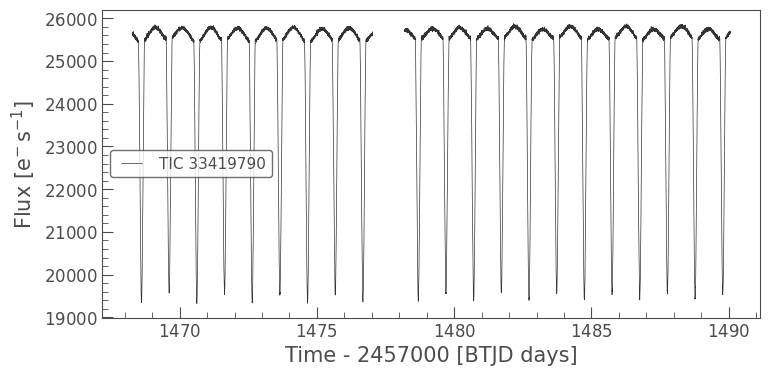

In [ ]:
lc.plot()